In [1]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams.update({'font.size': 14})

In [2]:
paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00001.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00002.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00003.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00004.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00005.nc',
        ]
paths1 = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00001.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00002.nc',
          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00003.nc',
        ]

ds_10min = xroms.open_mfnetcdf(paths, 
                                chunks = {'ocean_time':1})
ds_10min, grid_hourly = xroms.roms_dataset(ds_10min, 
                                     Vtransform = None)

ds_hourly = xroms.open_mfnetcdf(paths1, 
                                chunks = {'ocean_time':1})
ds_hourly, grid_10min = xroms.roms_dataset(ds_hourly, 
                                     Vtransform = None)

xislice=slice(50,250) #note tendencies have x+1 stopping points
etaslice=slice(150,350)

#Open tef, tendency terms, and chi for hourly and 10 min history file frequency
tef_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_hourly_xi_50_250_eta_150_350.nc')
tendencies_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/tendencies/xi_50_250_eta_150_350/tendencies_nested_hourly_xi_50_250_eta_150_350.nc')
chi_hourly = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_nested_hourly_xi50250_eta150350.nc')

tef_10min = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350.nc')
tendencies_10min = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/tendencies/xi_50_250_eta_150_350/tendencies_nested_10min_xi_50_250_eta_150_350.nc')
chi_10min = xr.open_dataset('../outputs/mixing/xi_50_250_eta_150_350/dissipation_histogram_10min_xi50250_eta150350_sbin200.nc')

tef_10min_s200 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350_s200.nc')
tef_10min_s500 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350_s500.nc')
tef_10min_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_10min_xi_50_250_eta_150_350_s1000.nc')

chi_10min_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_histogram_10min_xi50250_eta150350_sbin1000.nc')

tef_hourly_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/transports/xi_50_250_eta_150_350/tef_nested_hourly_xi_50_250_eta_150_350_s1000.nc')
chi_hourly_s1000 = xr.open_dataset('/scratch/user/dylan.schlichting/tef/outputs/mixing/xi_50_250_eta_150_350/dissipation_histogram_hourly_xi50250_eta150350_sbin1000.nc')


![image.png](attachment:f2344853-31f9-49d2-87f6-a5dd2d99cb45.png)

Text(0.5, 1.0, 'Volume Transport - 1000 bins [m$^3$ s$^{-1}]$')

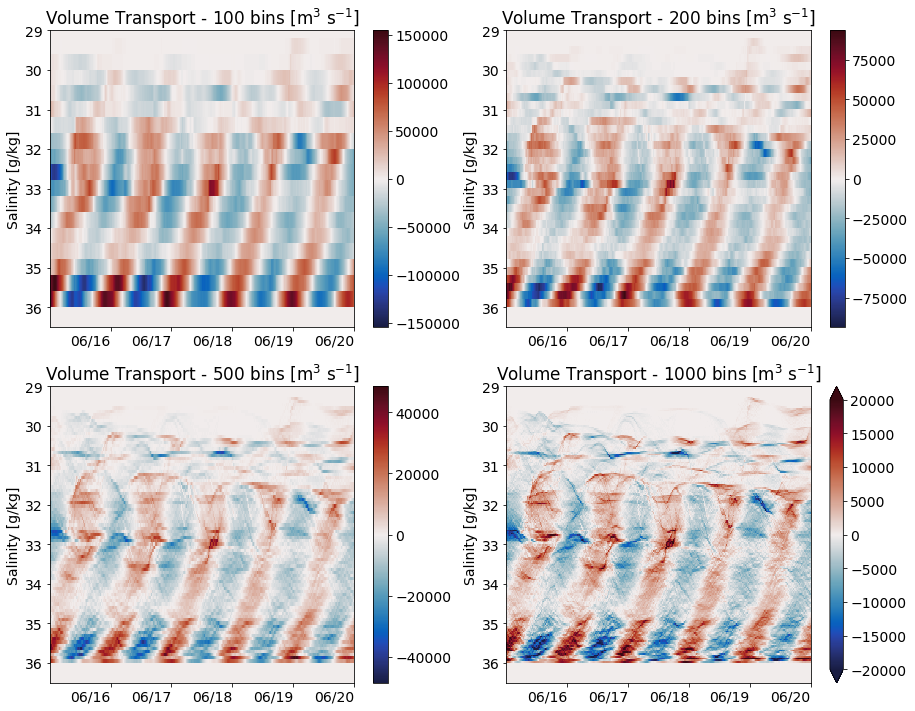

In [19]:
fig, axs = plt.subplots(2,2, figsize = (15,12))

tef_10min.Qnet.plot(y = 'salt_bin', 
                    cmap = cmo.balance,
                    ax = axs[0,0],
                    cbar_kwargs = {'label': ''})

tef_10min_s200.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0,1],
                        cbar_kwargs = {'label': ''})

tef_10min_s500.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[1,0],
                        cbar_kwargs = {'label': ''})
tef_10min_s1000.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[1,1],
                        cbar_kwargs = {'label': ''},
                        vmax = 20000)

myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0,0].set_title('Volume Transport - 100 bins [m$^3$ s$^{-1}]$')
axs[0,1].set_title('Volume Transport - 200 bins [m$^3$ s$^{-1}]$')
axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')
axs[1,1].set_title('Volume Transport - 1000 bins [m$^3$ s$^{-1}]$')

Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

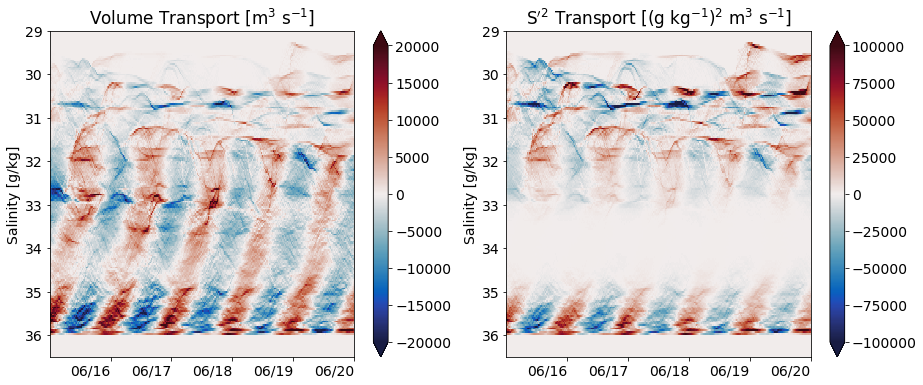

In [109]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

tef_10min_s1000.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = 20000)

tef_10min_s1000.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = 1e5)

myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0].set_title('Volume Transport [m$^3$ s$^{-1}]$')
axs[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')


Text(0.5, 1.0, 'S$^\\prime{^2}$ Dissipation [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

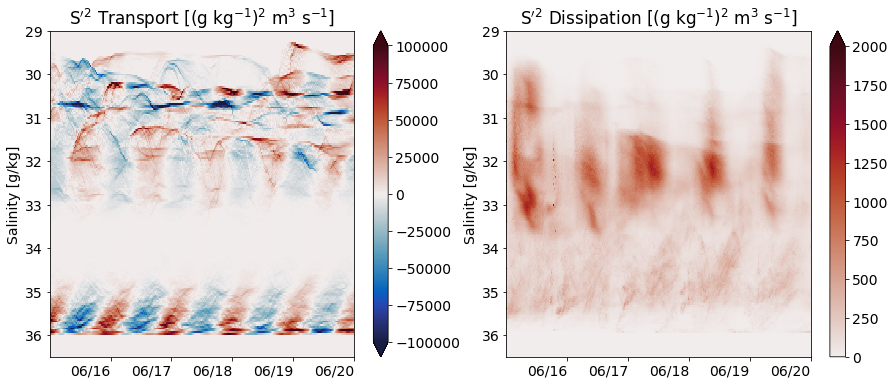

In [69]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

tef_10min_s1000.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = 1e5)

chi_10min_s1000.histogram_salt.plot(y = 'salt_bin', 
                        cmap = cmo.amp,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = 2e3)

myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (29,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
axs[1].set_title('S$^\prime{^2}$ Dissipation [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')

In [12]:
tef_hourly_s1000

<xarray.Dataset>
Dimensions:     (ocean_time: 787, salt_bin: 1000)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-03T01:00:00 ... 2010-07-0...
  * salt_bin    (salt_bin) float64 0.02 0.06 0.1 0.14 ... 39.86 39.9 39.94 39.98
Data variables:
    Qnet        (ocean_time, salt_bin) float64 ...
    Qin         (ocean_time) float64 ...
    Qout        (ocean_time) float64 ...
    Qsnet       (ocean_time, salt_bin) float64 ...
    Qsin        (ocean_time) float64 ...
    Qsout       (ocean_time) float64 ...
    Qssnet      (ocean_time, salt_bin) float64 ...
    Qssin       (ocean_time) float64 ...
    Qssout      (ocean_time) float64 ...
    Qsvarnet    (ocean_time, salt_bin) float64 ...
    Qsvarin     (ocean_time) float64 ...
    Qsvarout    (ocean_time) float64 ...
    sin         (ocean_time) float64 ...
    sout        (ocean_time) float64 ...
    ssin        (ocean_time) float64 ...
    ssout       (ocean_time) float64 ...
    svarin      (ocean_time) float64 ...
    svarout     (ocean_time) float64 ...
    voladv      (ocean_time) float64 ...
    saltadv     (ocean_time) float64 ...
    ssaltadv    (ocean_time) float64 ...
    svaradv     (ocean_time) float64 ...
Attributes:
    Description:  Exchange flow Dataset
    Author:       Dylan Schlichting
    Created:      2021-01-22T08:59:07.861798

In [14]:
chi_hourly_s1000.isel(ocean_time = slice(0,787))

<xarray.Dataset>
Dimensions:         (ocean_time: 787, salt_bin: 1000)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-03T01:00:00 ... 2010-...
  * salt_bin        (salt_bin) float64 0.02 0.06 0.1 0.14 ... 39.9 39.94 39.98
Data variables:
    histogram_salt  (ocean_time, salt_bin) float64 ...

In [60]:
from matplotlib import ticker
plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(2,1, figsize = (12,7), dpi = 1200, constrained_layout = True)

tef_hourly_s1000.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = plt.get_cmap('bwr'),
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = .75e5)

chi_hourly_s1000.isel(ocean_time = slice(0,787)).histogram_salt.plot(y = 'salt_bin', 
                        cmap = cmo.amp,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = 2e3)

myFmt = mdates.DateFormatter('%m/%d/%Y')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g kg$^{-1}$]',
           ylim = (25,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

axs[0].set_title('Salinity variance transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
axs[1].set_title('Salinity variance dissipation [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

M = 6
xticks = ticker.MaxNLocator(M)

axs[0].set_xticklabels('')
axs[0].set_xlim('2010-06-03', '2010-07-06')
axs[0].xaxis.set_major_locator(xticks)
axs[1].set_xlim('2010-06-03', '2010-07-06')
axs[1].xaxis.set_major_locator(xticks)

Text(0.5, 1.0, 'S$^\\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

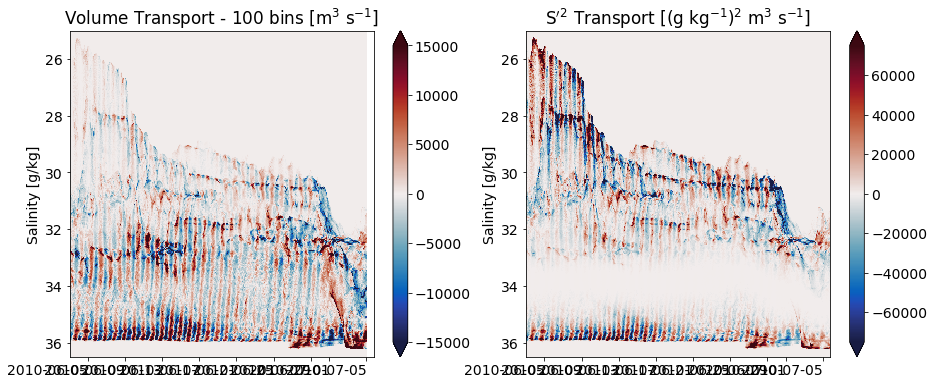

In [110]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

tef_hourly_s1000.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = 15000)

tef_hourly_s1000.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = .75e5)

myFmt = mdates.DateFormatter('%m')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (25,36.5),
           )
    ax.invert_yaxis()
#     ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0].set_title('Volume Transport - 100 bins [m$^3$ s$^{-1}]$')
axs[1].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')


In [150]:
 chi_hourly_s1000

<xarray.Dataset>
Dimensions:         (ocean_time: 1080, salt_bin: 1000)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-03T01:00:00 ... 2010-...
  * salt_bin        (salt_bin) float64 0.02 0.06 0.1 0.14 ... 39.9 39.94 39.98
Data variables:
    histogram_salt  (ocean_time, salt_bin) float64 ...

Text(0.5, 1.0, 'S$^\\prime{^2}$ Dissipation [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')

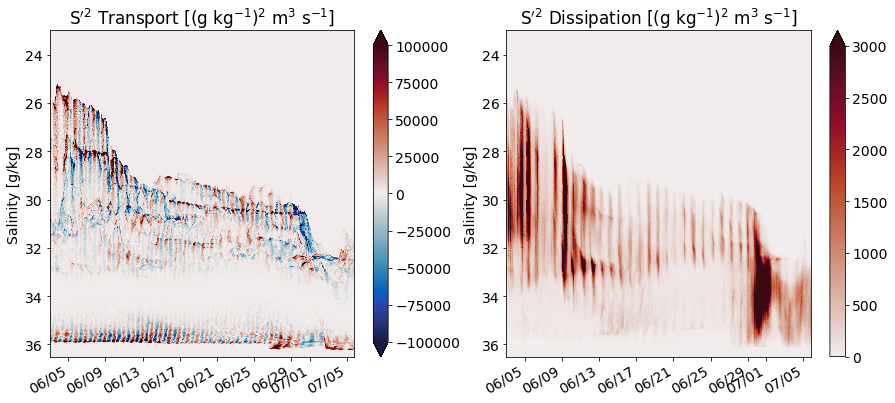

In [154]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

tef_hourly_s1000.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = 1e5)
test = chi_hourly_s1000.histogram_salt.sel(ocean_time = slice('2010-06-03T01:00:00', '2010-07-05T19:00:00.000000000'))
test.plot(y = 'salt_bin', 
                        cmap = cmo.amp,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = 3e3)

myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (23,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
#     plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0].set_title('S$^\prime{^2}$ Transport [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
axs[1].set_title('S$^\prime{^2}$ Dissipation [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}]$')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')

### Directly compare the histograms during the model overlap period.

In [147]:
tef_hourly_s1000.ocean_time[-1]

<xarray.DataArray 'ocean_time' ()>
array('2010-07-05T19:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2010-07-05T19:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [36]:
print(ds_10min.ocean_time[0].values)
print(ds_10min.ocean_time[-1].values)

2010-06-15T00:10:00.000000000
2010-06-20T00:00:00.000000000


In [80]:
tefhourlysub = tef_hourly_s1000.sel(ocean_time = slice('2010-06-15T00:10:00.000000000', 
                                                    '2010-06-20T00:10:00.000000000'))

tef10minsub = tef_10min_s1000.sel(ocean_time = slice('2010-06-15T01:00:00.000000000', 
                                                    '2010-06-20T00:10:00.000000000'))

chihourlysub = chi_hourly_s1000.sel(ocean_time = slice('2010-06-15T00:10:00.000000000', 
                                                    '2010-06-20T00:10:00.000000000'))

chi10minsub = chi_10min_s1000.sel(ocean_time = slice('2010-06-15T01:00:00.000000000', 
                                                    '2010-06-20T00:10:00.000000000'))

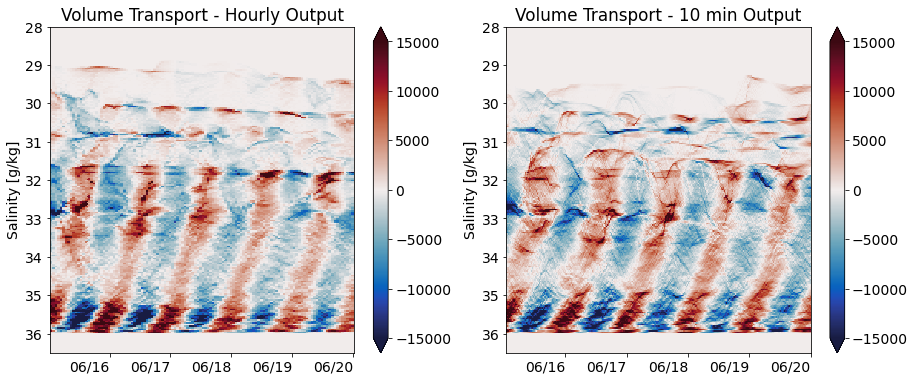

In [85]:
fig, axs = plt.subplots(1,2, figsize = (15,6))

tefhourlysub.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0],
                        cbar_kwargs = {'label': ''},
                        vmax = 15000)

tef10minsub.Qnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[1],
                        cbar_kwargs = {'label': ''},
                        vmax = 15000)

myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (28,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0 )

axs[0].set_title('Volume Transport - Hourly Output')
axs[1].set_title('Volume Transport - 10 min Output')
# axs[1,0].set_title('Volume Transport - 500 bins [m$^3$ s$^{-1}]$')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

Text(0.5, 1.0, 'S$^\\prime{^2}$ Dissipation - 10 min Output')

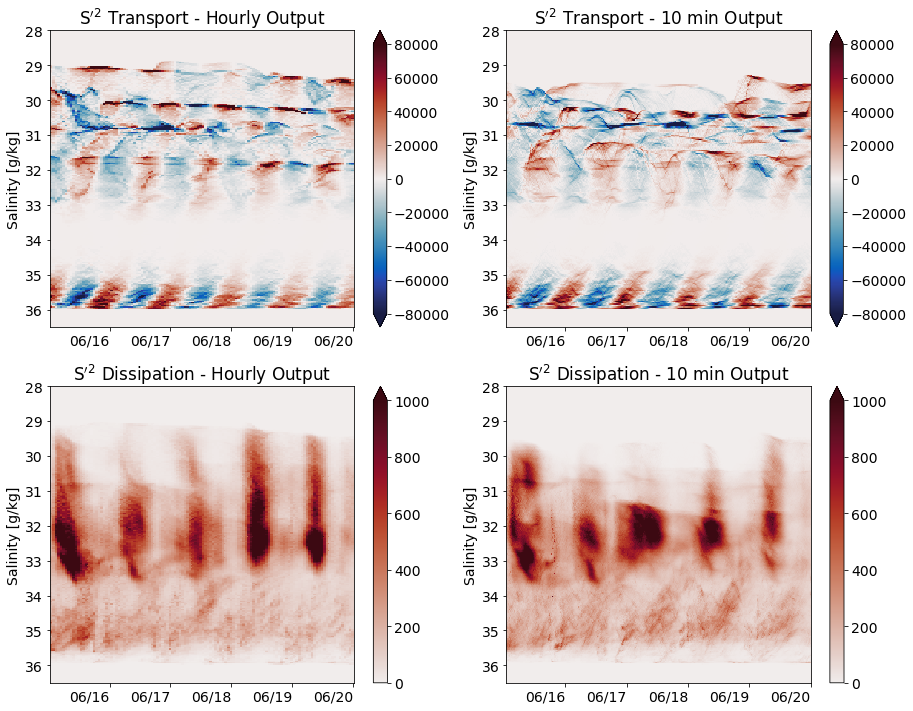

In [90]:
fig, axs = plt.subplots(2,2, figsize = (15,12))

tefhourlysub.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0,0],
                        cbar_kwargs = {'label': ''},
                        vmax = 80000)

tef10minsub.Qsvarnet.plot(y = 'salt_bin', 
                        cmap = cmo.balance,
                        ax = axs[0,1],
                        cbar_kwargs = {'label': ''},
                        vmax = 80000)

chihourlysub.histogram_salt.plot(y = 'salt_bin', 
                        cmap = cmo.amp,
                        ax = axs[1,0],
                        cbar_kwargs = {'label': ''},
                        vmax = 1e3)

chi10minsub.histogram_salt.plot(y = 'salt_bin', 
                        cmap = cmo.amp,
                        ax = axs[1,1],
                        cbar_kwargs = {'label': ''},
                        vmax = 1e3)
myFmt = mdates.DateFormatter('%m/%d')

for ax in axs.flat:
    ax.set(xlabel = '', 
           ylabel = 'Salinity [g/kg]',
           ylim = (28,36.5),
           )
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

axs[0,0].set_title(r'S$^\prime{^2}$ Transport - Hourly Output')
axs[0,1].set_title(r'S$^\prime{^2}$ Transport - 10 min Output')
axs[1,0].set_title('S$^\prime{^2}$ Dissipation - Hourly Output')
axs[1,1].set_title('S$^\prime{^2}$ Dissipation - 10 min Output')

# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

### Plot time series of some of chi to see the volume-integrated effects

Text(0, 0.5, '[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')

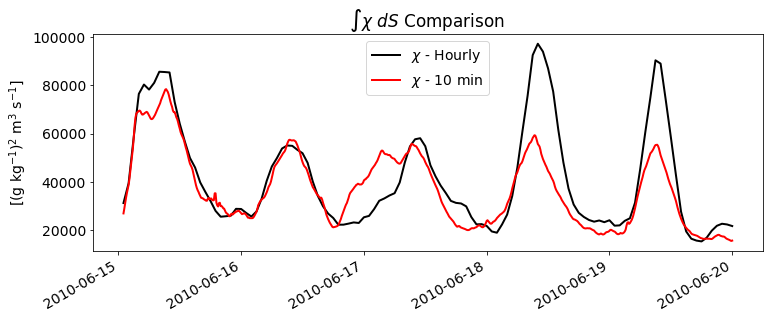

In [138]:
fig = plt.subplots(1, figsize = (12,4))

chihourlysub.histogram_salt.sum('salt_bin').plot(color = 'k', lw = 2, label = r'$\chi$ - Hourly')
chi10minsub.histogram_salt.sum('salt_bin').plot(color = 'r', lw = 2, label = r'$\chi$ - 10 min')

plt.legend()
plt.title('$\int \chi \, \,  dS$ Comparison ')
plt.xlabel('')
plt.ylabel('[(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')

In [117]:
chi10minsub

<xarray.Dataset>
Dimensions:         (ocean_time: 715, salt_bin: 1000)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2010-06-15T01:00:00 ... 2010-...
  * salt_bin        (salt_bin) float64 0.02 0.06 0.1 0.14 ... 39.9 39.94 39.98
Data variables:
    histogram_salt  (ocean_time, salt_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

Text(0, 0.5, '[(g kg$^{-1}$)$^2$ m$^3$]')

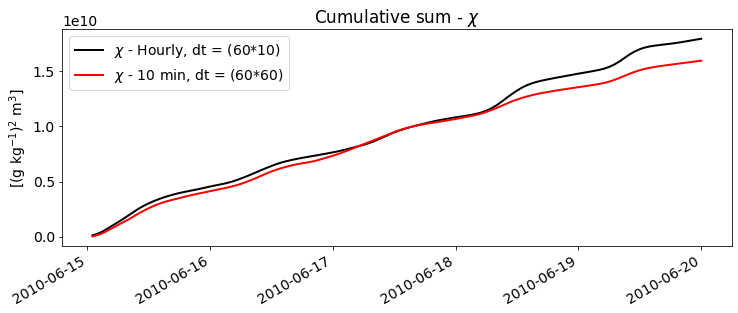

In [137]:
fig = plt.subplots(1, figsize = (12,4))

(chihourlysub.histogram_salt.sum('salt_bin').cumsum()*(60*60)).plot(color = 'k', lw = 2, label = r'$\chi$ - Hourly, dt = (60*10)')
(chi10minsub.histogram_salt.sum('salt_bin').cumsum()*(60*10)).plot(color = 'r', lw = 2, label = r'$\chi$ - 10 min, dt = (60*60)')

plt.title('Cumulative sum - $\chi$')
plt.legend()
plt.xlabel('')
plt.ylabel('[(g kg$^{-1}$)$^2$ m$^3$]')

In [123]:
chi10minsub.histogram_salt.sum().values*(60*10)

15970881861.351078

In [114]:
4989554/1E6

4.989554